In [1]:
import sys
sys.path.append('../Codes/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d

style.use('seaborn-paper')
print(style.available)
%autosave 60

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


Autosaving every 60 seconds


## Generating Sequences

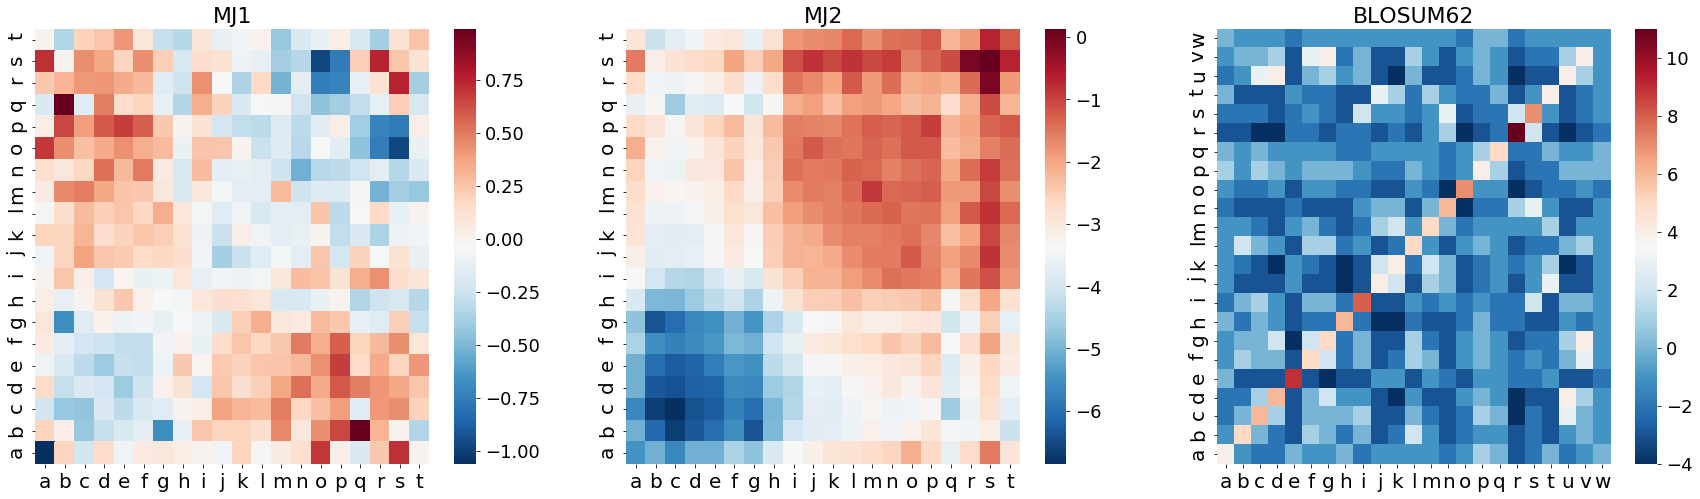

In [3]:
M1 = np.loadtxt('../Text_files/MJ.txt', skiprows= 1, usecols=range(1,21)).tolist()
M2 = np.loadtxt('../Text_files/MJ2.txt', skiprows= 1, usecols=range(1,21)).tolist()
M3 = np.loadtxt('../Text_files/BLOSUM62.txt', skiprows= 1, max_rows = 23, usecols=range(1,24)).tolist()
Alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't']
Alphabet2 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']
fig, ax = plt.subplots(1,3,figsize=(30,8))

plot_energy_matrix(Energy_Matrix = M1, Alphabet = Alphabet, title = 'MJ1', ax = ax[0])
plot_energy_matrix(Energy_Matrix = M2, Alphabet = Alphabet, title = 'MJ2', ax = ax[1])
plot_energy_matrix(Energy_Matrix = M3, Alphabet = Alphabet2, title = 'BLOSUM62', ax = ax[2])



In [2]:
%%time
n_seq = 100000

#Sequences = generate_Sequences(n_seq, Energy_Matrix = )
#pickle.dump( Sequences, open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "wb" ) )

Sequences = pickle.load( open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "rb" ) )

#print_raw_file(Sequences, "../Text_files/file2.txt")
#generate_newick_format("../Text_files/file2.txt")


CPU times: user 3.9 s, sys: 411 ms, total: 4.32 s
Wall time: 4.46 s


In [3]:
Sequences[8000].master_sequence, Sequences[8000].sequence, Sequences[8000].hamming_distance, Sequences[8000].energy_parent, Sequences[8000].energy, Sequences[8000].delta_energy, Sequences[0].energy

('odsadmgao',
 'mdnbdmgat',
 4,
 -3.1000000000000014,
 -3.1200000000000014,
 -0.01999999999999999,
 -5.500000000000001)

In [4]:
fig, ax = plt.subplots(1,3,figsize=(30,8))

distances = plot_histogram_hamming_distance(Sequences = Sequences, ax = ax[0])
energies = plot_histogram_energy(Sequences = Sequences, bins = 100, ax = ax[1])
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, ax = ax[2])

fig.savefig('../Figures/Sequences-n_seq-%d.png'%(n_seq))
plt.close()


## Stochastic Simulation

In [38]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 0.2
R=6
beta = 1
gamma = 1
T = 7
Sub_Sequences = np.random.choice(Sequences, n_linages)
Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                              nu = nu, R = R, beta = beta, master_Sequence_energy = 0)
Model.Gillespie()


CPU times: user 2min 32s, sys: 1min 49s, total: 4min 21s
Wall time: 4min 31s


In [40]:
fig, ax = plt.subplots(3,2,figsize=(20,24))

plot_energy_matrix(Energax = ax[0,0])
Model.plot_antigen_time(ax = ax[0,1])
Model.plot_prob_binding(ax = ax[1,0])
Model.stackplot_linages_time(antigen = False, time = True, ax = ax[1,1])
Model.hist_sequences_hamming_distance(Sequences = Sequences, ax = ax[2,0])
Model.hist_sequences_energy(Sequences = Sequences, bins = 100, ax = ax[2,1])


counter = 0
while(os.path.isfile('../Figures/Antigen_Linages_%d.png'%(counter))):
    counter+=1
    
fig.savefig('../Figures/Antigen_Linages_%d.png'%(counter))
plt.close()


In [9]:
fig, ax = plt.subplots(4,2,figsize=(20,32))

for i, k in enumerate([4, 10, 50, 100]):

    biggest_k_linages_freq = Model.plot_k_largest_linages(k=k, ax=ax[i,0])
    Model.plot_entropy_k_largest_linages(k=k, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[i,1])

counter = 0
while(os.path.isfile('../Figures/Entropy_%d.png'%(counter))):
    counter+=1
    
fig.savefig('../Figures/Entropy_%d.png'%(counter))
plt.close()


In [10]:
Model.activation_time_series.shape

(200, 1168)

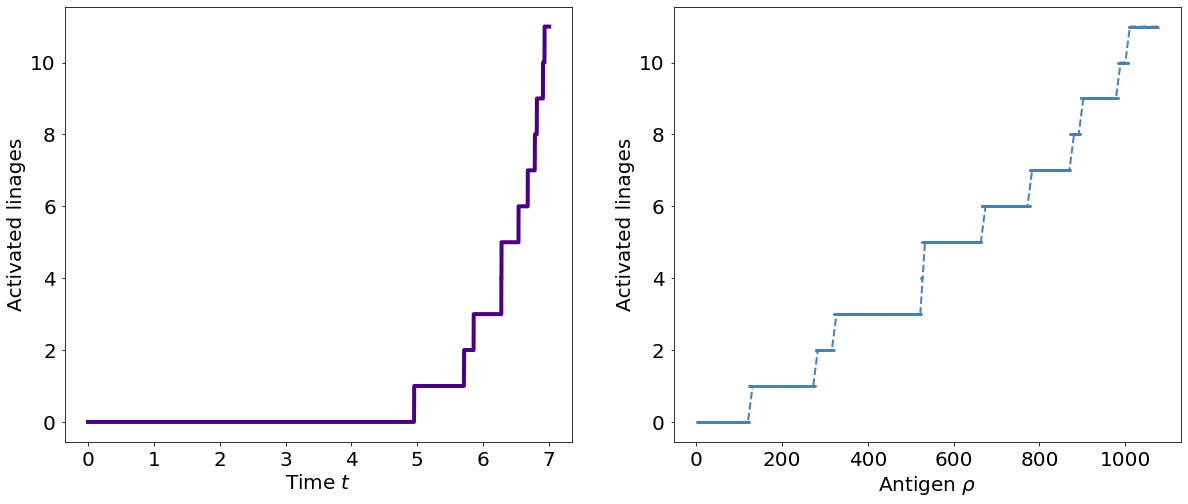

In [28]:
activation_time_series = [np.sum(Model.activation_time_series[:,i]) for i in range(int(len(Model.activation_time_series[0,:])))]
f = interp1d(Model.antigen_time_series, activation_time_series)
x_new = np.linspace(1, np.max(Model.antigen_time_series), 100)
fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].plot(Model.time_series, activation_time_series, linewidth = 4, color = 'indigo')
ax[0].set_xlabel(r'Time $t$', fontsize = 20)
ax[0].set_ylabel(r'Activated linages', fontsize = 20)
ax[0].tick_params(labelsize = 20)
#ax[0].set_yscale('log')
#ax[0].legend(loc = 0, fontsize = 20)

ax[1].plot(Model.antigen_time_series, activation_time_series, '.', ms = 5, linewidth = 4, color = 'steelblue')
ax[1].plot(x_new, f(x_new), '--', linewidth = 2, color = 'steelblue')
ax[1].set_xlabel(r'Antigen $\rho$', fontsize = 20)
ax[1].set_ylabel(r'Activated linages', fontsize = 20)
ax[1].tick_params(labelsize = 20)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].legend(loc = 0, fontsize = 20)



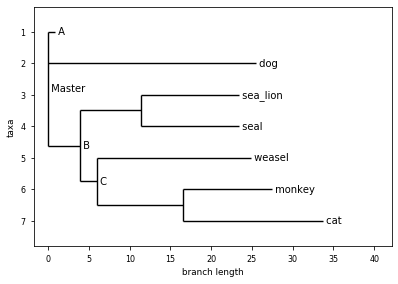

In [21]:
tree = Phylo.read(StringIO("Master(A():0.84600,B((sea_lion:11.99700, seal:12.00300):7.52973,C((monkey:10.85930,cat:17.14069):10.59201, weasel:18.87953):2.09460):3.87382,dog:25.46154):0"), "newick")
tree.ladderize()  # Flip branches so deeper clades are displayed at top
Phylo.draw(tree)

# Ensemble of systems

## Distribution of linage sizes

In [21]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 0.2
R=6
beta = 1
gamma = 1
T = 5

#_____ Choose one of the following____________________________________
#activated_linages_size_t = []
activated_linages_size_t = pickle.load( open( "../Text_files/activated_linages_size_t-%d.pkl"%(n_seq), "rb" ) )
#_____________________________________________________________________

for i in range(1000):
    Sub_Sequences = np.random.choice(Sequences, n_linages)
    Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                                  nu = nu, R = R, beta = beta, master_Sequence_energy = 12)
    Model.Gillespie()
    if(i%100==0):
        print(i, '...')
        print(Model.time_series[-1], Model.antigen_time_series[-1])
    activated_linages_size_t = np.append(activated_linages_size_t, [Model.linages_time_series[i,-1] for i in range(n_linages) if Model.Sequences[i].active])
        
pickle.dump(activated_linages_size_t, open( "../Text_files/activated_linages_size_t-%d.pkl"%(n_seq), "wb" ) )
print(len(activated_linages_size_t))

0 ...
5.000881548580659 1041
100 ...
5.000540838713413 842
200 ...
5.00069222476885 1897
300 ...
5.00067871314649 1631
400 ...
5.000266268106022 1377
500 ...
5.000431750225321 1925
600 ...
5.000523907367317 2198
700 ...
5.000002224028241 1206
800 ...
5.000272188111698 1775
900 ...
5.001068884351166 2125
11149
CPU times: user 1h 51min 30s, sys: 18min 20s, total: 2h 9min 50s
Wall time: 2h 10min 12s


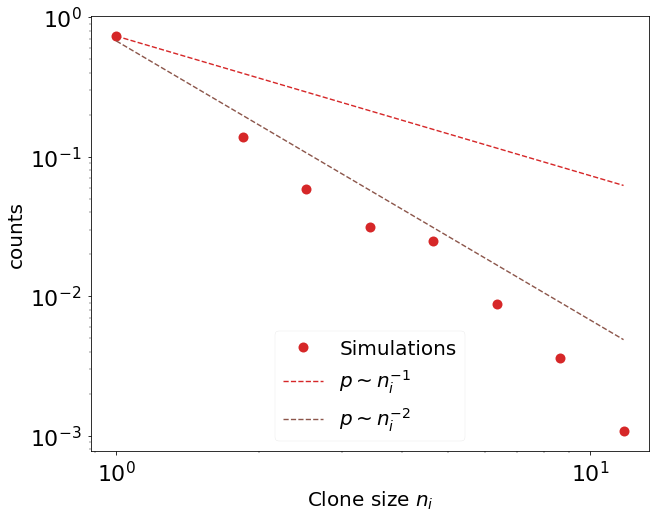

In [22]:
activated_linages_size_t = pickle.load( open( "../Text_files/activated_linages_size_t-%d.pkl"%(n_seq), "rb" ) )
data_activated_linages = np.histogram(activated_linages_size_t, bins = np.logspace(0,np.log10(np.max(activated_linages_size_t)),10))

fig, ax = plt.subplots(1, 1, figsize = (10,8))
#ax.plot(data_activated_linages[1][:-1], np.cumsum(data_activated_linages[0]), marker = '.', ms = 20, linestyle = '--', linewidth = 4, color = 'tab:red')
ax.plot(data_activated_linages[1][:-1], data_activated_linages[0]/np.sum(data_activated_linages[0]), marker = '.', ms = 20, linestyle = '', linewidth = 4, color = 'tab:red', label = 'Simulations')
ax.plot(data_activated_linages[1][:-1], (data_activated_linages[0][0]/np.sum(data_activated_linages[0]))*(data_activated_linages[1][:-1])**(-1), linestyle = '--', color = 'tab:red', label = r'$p\sim n_i^{-1}$')
ax.plot(data_activated_linages[1][:-1], 100*4.5*np.exp(5.5-12)*((data_activated_linages[1][:-1]))**(-2), linestyle = '--', color = 'tab:brown', label = r'$p\sim n_i^{-2}$')
#ax.plot(data_activated_linages[1][:-1], 100000*4.5*np.exp(5.5-12)*((data_activated_linages[1][:-1]))**(-2), linestyle = '--', color = 'tab:brown')

ax.set_xlabel(r'Clone size $n_i$', fontsize = 20)
ax.set_ylabel(r'counts', fontsize = 20)
ax.tick_params(labelsize = 22)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 0, fontsize = 20)

counter = 0
while(os.path.isfile('../Figures/Linages_size_distribution_%d.png'%(counter))):
    counter+=1
    
fig.savefig('../Figures/Linages_size_distribution_%d.png'%(counter))
#plt.close()

## Activation rate

In [25]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 0.2
R=6
beta = 1
gamma = 1
T = 5

activation_time_series_rho = np.zeros(40)
activation_time_series_rho_2 = np.zeros(40)
#activation_time_series_t = np.zeros(40)
max_rho = 6e2
rho_new = np.linspace(10, max_rho, 40)
#t_new = np.linspace(0, 4, 50)

counter = 0
for i in range(100):
    Sub_Sequences = np.random.choice(Sequences, n_linages)
    Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                                  nu = nu, R = R, beta = beta, master_Sequence_energy = 12)
    Model.Gillespie()
    if(i%10==0):
        print(i, '...')
        print(Model.time_series[-1], Model.antigen_time_series[-1])
    activation_time_series_i = [np.sum(Model.activation_time_series[:,i]) for i in range(int(len(Model.activation_time_series[0,:])))]
    f_rho = interp1d(Model.antigen_time_series, activation_time_series_i)
    #f_t = interp1d(Model.time_series, activation_time_series_i)
    activation_time_series_rho = activation_time_series_rho + f_rho(rho_new)
    activation_time_series_rho_2 = activation_time_series_rho_2 + (f_rho(rho_new))**2
    #activation_time_series_t = activation_time_series_t + f_t(t_new)
    counter += 1
    #else:
        #print('The maximum antigen was:', Model.antigen_time_series[-1])
        
activation_time_series_rho = activation_time_series_rho/(counter)
activation_time_series_rho_2 = (activation_time_series_rho_2)/(counter)
activation_time_series_rho_var = activation_time_series_rho_2-activation_time_series_rho**2
#activation_time_series_t = activation_time_series_t/counter

pickle.dump(activation_time_series_rho, open( "../Text_files/activation_time_series_rho-%d.pkl"%(n_seq), "wb" ) )
pickle.dump(activation_time_series_rho_var, open( "../Text_files/activation_time_series_rho_var-%d.pkl"%(n_seq), "wb" ) )

print(counter)


0 ...
5.0003927357064395 2604


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


100
CPU times: user 13min 48s, sys: 2min 34s, total: 16min 23s
Wall time: 17min 5s


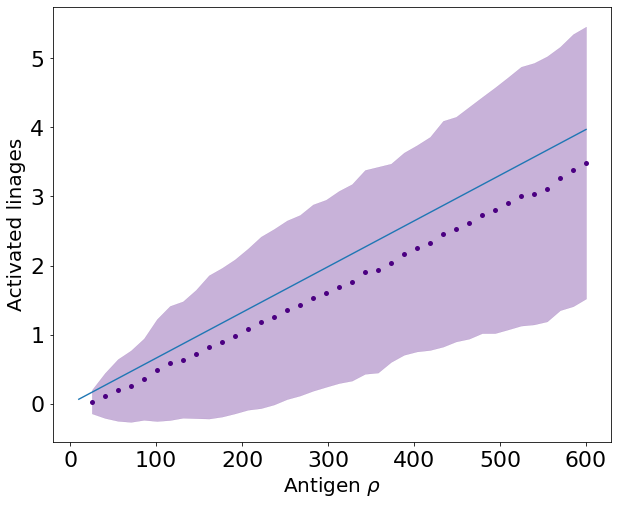

In [31]:
rho_new = np.linspace(10, max_rho, 40)
activation_time_series_rho = pickle.load( open( "../Text_files/activation_time_series_rho-%d.pkl"%(n_seq), "rb" ) )
activation_time_series_rho_var = pickle.load( open( "../Text_files/activation_time_series_rho_var-%d.pkl"%(n_seq), "rb" ) )

fig, ax = plt.subplots(1,1,figsize=(10,8))
gamma = 1
R_0 = 12

ax.plot(rho_new, activation_time_series_rho, '.', ms = 10, linewidth = 4, color = 'indigo')
ax.fill_between(rho_new, activation_time_series_rho-np.sqrt(activation_time_series_rho_var), activation_time_series_rho + np.sqrt(activation_time_series_rho_var), color='indigo', alpha = 0.3)
#ax.plot(rho_new, (1/gamma)*(rho_new*np.exp(-12-(-5))-1))
ax.plot(rho_new, 4.4*(rho_new*np.exp(-12-(-5.5))))
ax.set_xlabel(r'Antigen $\rho$', fontsize = 20)
ax.set_ylabel(r'Activated linages', fontsize = 20)
ax.tick_params(labelsize = 22)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.legend(loc = 0, fontsize = 20)

#________________________________________________________________________________________

counter = 0
while(os.path.isfile('../Figures/Activation_rate_%d.png'%(counter))):
    counter+=1
    
fig.savefig('../Figures/Activation_rate_%d.png'%(counter))
#plt.close()


(0.5, 10000.0)

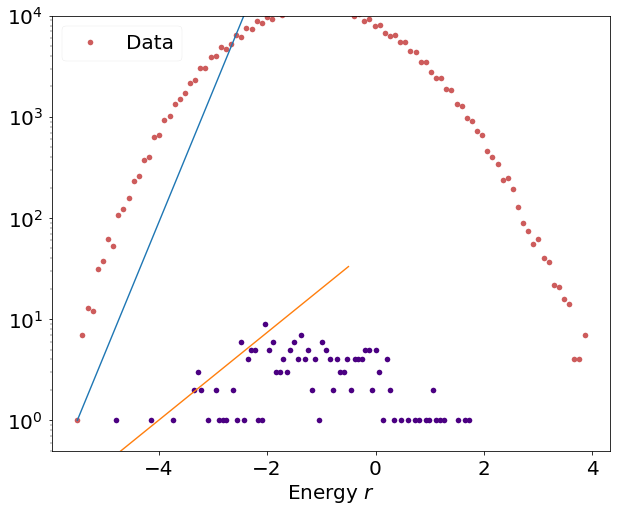

In [36]:
fig, ax = plt.subplots(1,1, figsize = (10, 8))
#___________________________________________
energies = plot_histogram_energy(Sequences = Sequences, bins = 100, ax = ax)
r_array = np.linspace(np.min(energies), np.min(energies)+5, 50)
r_array_2 = np.linspace(-4, -2, 50)
ax.plot(r_array, 1*np.exp(3*(r_array+5.5)))
#___________________________________________
Sub_Sequences = np.random.choice(Sequences, n_linages)
sub_energies = np.array([i.energy for i in Sub_Sequences])
data_energies = np.histogram(sub_energies, bins=100)
ax.plot(data_energies[1][0:-1], data_energies[0], linewidth = 4, color = 'indigo', label = 'Data', linestyle = '', marker = 'o')
ax.plot(r_array, np.exp(1*(r_array+4)))
#___________________________________________   
#ax.set_xlim(np.min(energies)-0.1, np.min(energies)+2)
ax.set_ylim(0.5, 1e4)

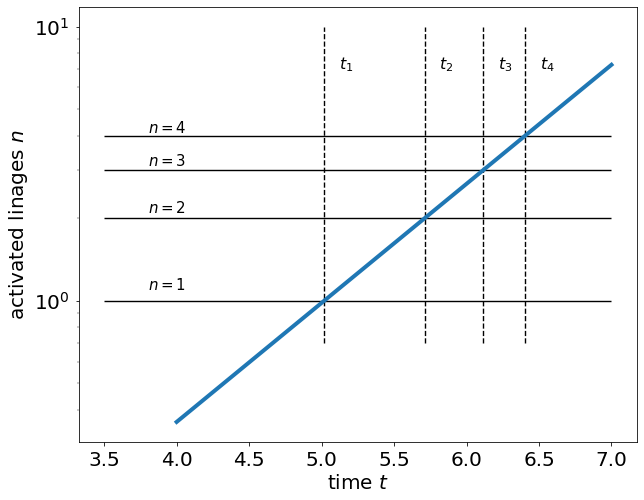

In [37]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

t = np.linspace(4, 7, 50)
N_b = 4.4*np.exp(+5.5-12)*np.exp(t)

ax.plot(t, N_b, linewidth = 4)

ax.hlines([1, 2, 3, 4], 3.5, 7)
ax.vlines(np.log((np.array([1,2,3,4])*np.exp(-5.5+12))/(4.4)), .7, 10, linestyle = 'dashed')

ax.text(3.8,1.1, r'$n = 1$', fontsize = 15)
ax.text(3.8,2.1, r'$n = 2$', fontsize = 15)
ax.text(3.8,3.1, r'$n = 3$', fontsize = 15)
ax.text(3.8,4.1, r'$n = 4$', fontsize = 15)

ax.text(np.log((np.array([1])*np.exp(-5.5+12))/(4.4)) + .1 ,7, r'$t_1$', fontsize = 16)
ax.text(np.log((np.array([2])*np.exp(-5.5+12))/(4.4)) + .1 ,7, r'$t_2$', fontsize = 16)
ax.text(np.log((np.array([3])*np.exp(-5.5+12))/(4.4)) + .1 ,7, r'$t_3$', fontsize = 16)
ax.text(np.log((np.array([4])*np.exp(-5.5+12))/(4.4)) + .1 ,7, r'$t_4$', fontsize = 16)

#ax.text(0, 20, r'$t_n \approx \ln{\left(\frac{n}{UR}\right)} + R_0$', fontsize = 25)
ax.set_xlabel(r'time $t$', fontsize = 20)
ax.set_ylabel(r'activated linages $n$', fontsize = 20)
ax.set_yscale('log')
ax.tick_params(labelsize = 20)
#ax.legend(fontsize = 20)
#fig.savefig('../Figures/first_k_times.png')

In [8]:
Sequences2 = pickle.load( open( "../Text_files/Sequences-n_seq-%d.pkl"%(100), "rb" ) )

fig, ax = plt.subplots(1,3,figsize=(30,8))

distances = plot_histogram_hamming_distance(Sequences = Sequences2, ax = ax[0])
energies = plot_histogram_energy(Sequences = Sequences2, bins = 100, ax = ax[1])
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, ax = ax[2])

fig.savefig('../Figures/Sequences-n_seq-%d.png'%(100))
plt.close()

